# Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
from torchvision import datasets, models, transforms
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random
import time
from PIL import Image

In [2]:
test = pd.read_csv('test_large_4.0.csv')

In [3]:
train= pd.read_csv('train_large_4.0.csv')

In [4]:
train

,path,font,char,code,label
0,char\瑞字\瑞字 楷书 柳公权.jpg,0,瑞,1087,0 1087
1,char\越字\越字 隶书 钱松.jpg,1,越,1659,1 1659
2,char\胡字\胡字 草书 沈学植.jpg,3,胡,1366,3 1366
3,char\攸字\攸字 行书 饶介.jpg,2,攸,725,2 725
4,char\概字\概字 草书 毛泽东.jpg,3,概,855,3 855
...,...,...,...,...,...
51456,char\锥字\锥字 楷书 柳公权.jpg,0,锥,1817,0 1817
51457,char\敝字\敝字 篆书 说文解字.jpg,4,敝,732,4 732
51458,char\区字\区字 篆书 吴昌硕.jpg,4,区,220,4 220
51459,char\吟字\吟字 楷书 王知敬.jpg,0,吟,272,0 272


# Model

In [9]:
class MyModel(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(MyModel, self).__init__()
        self.eps = 1
        self.k=torch.FloatTensor([10])
        self.model_resnet = models.resnet50(pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_classes1)
        self.fc2 = nn.Linear(4096, num_classes2)
        self.softmax = nn.Softmax(dim=1)
        self.embed =nn.Embedding(5, 2048)

    def font_code(self,y):
        ret=torch.FloatTensor().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        for i, x in enumerate(y):
            result=self.embed(x)
            result=torch.reshape(result, (1,2048))
            ret=torch.cat((ret, result))
        return ret
    def predict_font_code(self,y):
        ret=torch.FloatTensor().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        for i, x in enumerate(y):
            num=torch.topk(x,1)[1]
            result=self.embed(num)
            result=torch.reshape(result, (1,2048))
            ret=torch.cat((ret, result))
        return ret
    def forward(self, x,y):
        x = self.model_resnet(x)
        out1 = self.fc1(x)
        p = torch.rand(1).item()
        font = self.predict_font_code(out1)
        #if p < self.k / (self.k + torch.exp(self.eps / self.k)):
        #    font = self.font_code(y)
        #else:
        #    font = self.predict_font_code(out1)
        #font = self.predict_font_code(out1)
        self.eps +=1
        combined = torch.cat((x.view(x.size(0), -1),font.view(font.size(0), -1)), dim=1)
        out2 = self.fc2(combined)
        return out1, out2

In [10]:
model = MyModel(5,1999)

In [11]:
def training(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_loss1 = 0
    epoch_loss2 = 0
    epoch_acc1 = 0
    epoch_acc2 = 0
    epoch_acc3 = 0
    model.train()
    
    for x, y1,y2 in iterator:
        
        x = x.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        
        optimizer.zero_grad()
                
        outputs = model(x,y1)
        
        loss1 = criterion(outputs[0], y1)
        loss2 = criterion(outputs[1], y2)
        loss = loss1 + loss2 
        
        acc1 = calculate_accuracy(outputs[0], y1)
        acc2 = calculate_accuracy(outputs[1], y2)
        #gender_corrects += torch.sum(torch.topk(outputs[0], 1)[1] == torch.topk(y1, 1)[1])
        acc3 = calculate_10_accuracy(outputs[1], y2)
        
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_loss1 += loss1.item()
        epoch_loss2 += loss2.item()
        epoch_acc1 += acc1.item()
        epoch_acc2 += acc2.item()
        epoch_acc3 += acc3.item()
    return epoch_loss / len(iterator),epoch_loss1 / len(iterator),epoch_loss2 / len(iterator), epoch_acc1 / len(iterator),epoch_acc2 / len(iterator),epoch_acc3 / len(iterator)

In [12]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_loss1 = 0
    epoch_loss2 = 0
    epoch_acc1 = 0
    epoch_acc2 = 0
    epoch_acc3 = 0
    model.eval()
    
    with torch.no_grad():
    
        for x, y1,y2 in iterator:
        
            x = x.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
        
            optimizer.zero_grad()
                
            outputs = model(x,y1)
        
            loss1 = criterion(outputs[0], y1)
            loss2 = criterion(outputs[1], y2)
            loss = loss1 + loss2 
        
            acc1 = calculate_accuracy(outputs[0], y1)
            acc2 = calculate_accuracy(outputs[1], y2)
            acc3 = calculate_10_accuracy(outputs[1], y2)

            epoch_loss += loss.item()
            epoch_loss1 += loss1.item()
            epoch_loss2 += loss2.item()
            epoch_acc1 += acc1.item()
            epoch_acc2 += acc2.item()
            epoch_acc3 += acc3.item()
        
    return epoch_loss / len(iterator),epoch_loss1 / len(iterator),epoch_loss2 / len(iterator), epoch_acc1 / len(iterator),epoch_acc2 / len(iterator),epoch_acc3 / len(iterator)

In [13]:
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

In [14]:
class MultiTaskDataset():
    def __init__(self,df):
        self.paths = list(df.path)
        self.labels = list(df.label)

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = Image.open(self.paths[idx]).convert('RGB')
        img = preprocess(img)


        #dealing with the labels
        labels = self.labels[idx].split(" ")
        font = torch.tensor(int(labels[0]), dtype=torch.int64)
        code = torch.tensor(int(labels[1]), dtype=torch.int64)
        
        return img.data, font, code

    def show(self,idx):
        x,y = self.__getitem__(idx)
        font,code = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {}".format(font.item(), code.item()))

In [15]:
train_ds = MultiTaskDataset(train)

tr_dataloader=torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)

In [16]:
test_ds = MultiTaskDataset(test)

test_dataloader=torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=0)

In [17]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [18]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [19]:
def calculate_10_accuracy(y_pred, y):
    top_pred = torch.topk(y_pred,10)[1]
    y_resize = y.view(-1,1)
    correct = torch.eq(top_pred, y_resize).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Training

In [16]:
list_tr_loss=[]
list_font_loss=[]
list_char_loss=[]
list_font_acc=[]
list_char_acc=[]
list_char_10_acc=[]
list_ts_loss=[]
list_ts_font_loss=[]
list_ts_char_loss=[]
list_ts_font_acc=[]
list_ts_char_acc=[]
list_ts_char_10_acc=[]

In [27]:
list_tr_loss[0]

9.675166643628422

In [28]:
result=[]
for i in range(10):
    result.append([list_tr_loss[i],list_font_loss[i],list_char_loss[i],list_font_acc[i],list_char_acc[i],list_char_10_acc[i],list_ts_loss[i],list_ts_font_loss[i],list_ts_char_loss[i],list_ts_font_acc[i],list_ts_char_acc[i],list_ts_char_10_acc[i]])

In [30]:
result_df = pd.DataFrame(result, columns=['tr_loss','font_loss','char_loss','font_acc','char_acc','list_char_10_acc','list_ts_loss','list_ts_font_loss','list_ts_char_loss','list_ts_font_acc','list_ts_char_acc','list_ts_char_10_acc'])

In [31]:
result_df

,tr_loss,font_loss,char_loss,font_acc,char_acc,list_char_10_acc,list_ts_loss,list_ts_font_loss,list_ts_char_loss,list_ts_font_acc,list_ts_char_acc,list_ts_char_10_acc
0,9.675167,0.570227,9.104940,0.768556,0.002814,0.019352,7.749113,0.517171,7.231942,0.783712,0.016148,0.077309
1,6.172122,0.392985,5.779138,0.841250,0.076436,0.257519,4.300096,0.383530,3.916566,0.845332,0.213852,0.573584
2,2.991679,0.333745,2.657934,0.866363,0.414262,0.774387,2.307695,0.412481,1.895214,0.835842,0.559311,0.876722
3,1.574542,0.287732,1.286811,0.884375,0.686413,0.934317,1.560773,0.329350,1.231423,0.869796,0.708355,0.937666
4,1.007093,0.245832,0.761261,0.901727,0.802085,0.972403,1.257358,0.303992,0.953366,0.875446,0.769566,0.954974
5,0.706789,0.220082,0.486707,0.912116,0.868909,0.988024,1.272888,0.382625,0.890263,0.860625,0.790969,0.963571
6,0.528967,0.190473,0.338494,0.924864,0.905136,0.994720,1.159938,0.331959,0.827978,0.872028,0.806658,0.966569
7,0.414971,0.162287,0.252684,0.935194,0.926324,0.997050,1.060497,0.276058,0.784439,0.895880,0.824158,0.969069
8,0.321340,0.134727,0.186613,0.947484,0.945738,0.998389,1.401633,0.554076,0.847557,0.814196,0.815574,0.963839
9,0.285706,0.116660,0.169046,0.956102,0.950769,0.998280,1.121618,0.310987,0.810631,0.901199,0.829630,0.968176


In [32]:
result_df.to_csv('multitask_model_3.0-pred-11_29_train_more_data.csv', index=False)

In [17]:
for i in range(10):
    since=time.time()
    tr_loss,font_loss,char_loss,font_acc,char_acc,char_10_acc=training(model, tr_dataloader, optimizer, criterion, device)
    ts_loss,ts_font_loss,ts_char_loss,ts_font_acc,ts_char_acc,ts_char_10_acc=evaluate(model, test_dataloader, criterion, device)
    mins,secs=epoch_time(since,time.time())
    list_tr_loss.append(tr_loss)
    list_font_loss.append(font_loss)
    list_char_loss.append(char_loss)
    list_font_acc.append(font_acc)
    list_char_acc.append(char_acc)
    list_char_10_acc.append(char_10_acc)
    list_ts_loss.append(ts_loss)
    list_ts_font_loss.append(ts_font_loss)
    list_ts_char_loss.append(ts_char_loss)
    list_ts_font_acc.append(ts_font_acc)
    list_ts_char_acc.append(ts_char_acc)
    list_ts_char_10_acc.append(ts_char_10_acc)
    print('epochs:'+ str(i+1))
    print('min:'+str(mins)+' '+'sec:'+str(secs))
    print('training_loss:'+str(round(tr_loss, 5))+' font_loss:'+str(round(font_loss, 5))+' char_loss:'+str(round(char_loss, 5))+' font_accuracy:'+str(round(font_acc, 5))+' char_accuracy:'+str(round(char_acc, 5))+' char_accuracy:'+str(round(char_10_acc, 5)))
    print('test_loss:'+str(round(ts_loss, 5))+' font_loss:'+str(round(ts_font_loss, 5))+' char_loss:'+str(round(ts_char_loss, 5))+' font_accuracy:'+str(round(ts_font_acc, 5))+' char_accuracy:'+str(round(ts_char_acc, 5))+' char_accuracy:'+str(round(ts_char_10_acc, 5)))

epochs:1
min:16 sec:45
training_loss:9.67517 font_loss:0.57023 char_loss:9.10494 font_accuracy:0.76856 char_accuracy:0.00281 char_accuracy:0.01935
test_loss:7.74911 font_loss:0.51717 char_loss:7.23194 font_accuracy:0.78371 char_accuracy:0.01615 char_accuracy:0.07731
epochs:2
min:9 sec:57
training_loss:6.17212 font_loss:0.39298 char_loss:5.77914 font_accuracy:0.84125 char_accuracy:0.07644 char_accuracy:0.25752
test_loss:4.3001 font_loss:0.38353 char_loss:3.91657 font_accuracy:0.84533 char_accuracy:0.21385 char_accuracy:0.57358
epochs:3
min:9 sec:44
training_loss:2.99168 font_loss:0.33375 char_loss:2.65793 font_accuracy:0.86636 char_accuracy:0.41426 char_accuracy:0.77439
test_loss:2.3077 font_loss:0.41248 char_loss:1.89521 font_accuracy:0.83584 char_accuracy:0.55931 char_accuracy:0.87672
epochs:4
min:9 sec:44
training_loss:1.57454 font_loss:0.28773 char_loss:1.28681 font_accuracy:0.88438 char_accuracy:0.68641 char_accuracy:0.93432
test_loss:1.56077 font_loss:0.32935 char_loss:1.23142 fon

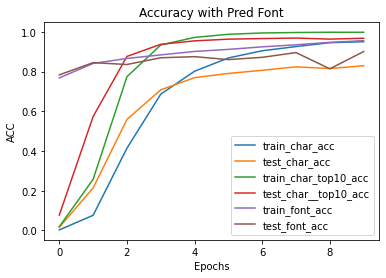

In [25]:
plt.plot(list_char_acc, label="train_char_acc")
plt.plot(list_ts_char_acc, label="test_char_acc")
plt.plot(list_char_10_acc, label="train_char_top10_acc")
plt.plot(list_ts_char_10_acc, label="test_char__top10_acc")
plt.plot(list_font_acc, label="train_font_acc")
plt.plot(list_ts_font_acc, label="test_font_acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("ACC")
plt.title('Accuracy with Pred Font')
plt.show()

In [ ]:
for i in range(10):
    since=time.time()
    tr_loss,font_loss,char_loss,font_acc,char_acc,char_10_acc=training(model, tr_dataloader, optimizer, criterion, device)
    ts_loss,ts_font_loss,ts_char_loss,ts_font_acc,ts_char_acc,ts_char_10_acc=evaluate(model, test_dataloader, criterion, device)
    mins,secs=epoch_time(since,time.time())
    list_tr_loss.append(tr_loss)
    list_font_loss.append(font_loss)
    list_char_loss.append(char_loss)
    list_font_acc.append(font_acc)
    list_char_acc.append(char_acc)
    list_char_10_acc.append(char_10_acc)
    list_ts_loss.append(ts_loss)
    list_ts_font_loss.append(ts_font_loss)
    list_ts_char_loss.append(ts_char_loss)
    list_ts_font_acc.append(ts_font_acc)
    list_ts_char_acc.append(ts_char_acc)
    list_ts_char_10_acc.append(ts_char_10_acc)
    print('epochs:'+ str(i+1))
    print('min:'+str(mins)+' '+'sec:'+str(secs))
    print('training_loss:'+str(round(tr_loss, 5))+' font_loss:'+str(round(font_loss, 5))+' char_loss:'+str(round(char_loss, 5))+' font_accuracy:'+str(round(font_acc, 5))+' char_accuracy:'+str(round(char_acc, 5))+' char_accuracy:'+str(round(char_10_acc, 5)))
    print('test_loss:'+str(round(ts_loss, 5))+' font_loss:'+str(round(ts_font_loss, 5))+' char_loss:'+str(round(ts_char_loss, 5))+' font_accuracy:'+str(round(ts_font_acc, 5))+' char_accuracy:'+str(round(ts_char_acc, 5))+' char_accuracy:'+str(round(ts_char_10_acc, 5)))

epochs:1
min:10 sec:47
training_loss:9.68626 font_loss:0.59673 char_loss:9.08953 font_accuracy:0.75368 char_accuracy:0.00274 char_accuracy:0.02057
test_loss:7.82089 font_loss:0.45233 char_loss:7.36857 font_accuracy:0.81216 char_accuracy:0.01524 char_accuracy:0.07506
epochs:2
min:11 sec:7
training_loss:6.25241 font_loss:0.38719 char_loss:5.86522 font_accuracy:0.84385 char_accuracy:0.06955 char_accuracy:0.24411
test_loss:4.45571 font_loss:0.53782 char_loss:3.91789 font_accuracy:0.78333 char_accuracy:0.218 char_accuracy:0.5814
epochs:3
min:11 sec:20
training_loss:3.08633 font_loss:0.33875 char_loss:2.74757 font_accuracy:0.86365 char_accuracy:0.39722 char_accuracy:0.76107
test_loss:2.20833 font_loss:0.35527 char_loss:1.85306 font_accuracy:0.85194 char_accuracy:0.57815 char_accuracy:0.87906
epochs:4
min:11 sec:16
training_loss:1.58311 font_loss:0.28469 char_loss:1.29842 font_accuracy:0.88481 char_accuracy:0.68415 char_accuracy:0.93253
test_loss:1.5143 font_loss:0.30833 char_loss:1.20598 fon

In [18]:
#torch.save(model.state_dict(), "D:/caligraphy/test_model3_more_pred.pth")

In [21]:
model.load_state_dict(torch.load("D:/caligraphy/test_model3_more_pred.pth"))

<All keys matched successfully>

# Confusion Matrix

In [20]:
a,b=evaluate_confusion(model, test_dataloader, criterion, device)

In [21]:
pred=[]
true=[]
for i in a:
    pred.append(i.numpy()[0])
for i in b:
    true.append(i.item())

In [40]:
pred

[4,
 2,
 1,
 2,
 1,
 3,
 2,
 1,
 2,
 4,
 2,
 2,
 2,
 1,
 2,
 0,
 1,
 4,
 0,
 1,
 1,
 2,
 0,
 3,
 1,
 2,
 3,
 3,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 4,
 2,
 1,
 3,
 1,
 4,
 2,
 3,
 1,
 3,
 1,
 1,
 2,
 3,
 1,
 0,
 4,
 2,
 0,
 1,
 1,
 0,
 2,
 2,
 1,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 0,
 2,
 2,
 3,
 2,
 1,
 1,
 4,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 3,
 2,
 2,
 4,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 2,
 4,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 3,
 0,
 0,
 2,
 2,
 2,
 3,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 3,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 4,
 1,
 1,
 2,
 4,
 4,
 1,
 3,
 1,
 2,
 2,
 1,
 2,
 3,
 3,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 3,
 2,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 4,
 2,
 2,
 1,
 2,
 4,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 4,
 3,
 2,
 1,
 1,
 2,
 2,
 2,
 4,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 0,


In [22]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

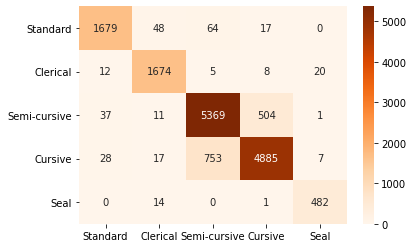

In [27]:
columns = ['Standard','Clerical','Semi-cursive','Cursive','Seal']

confm = confusion_matrix(true, pred)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')

In [26]:
confm

array([[1679,   48,   64,   17,    0],
       [  12, 1674,    5,    8,   20],
       [  37,   11, 5369,  504,    1],
       [  28,   17,  753, 4885,    7],
       [   0,   14,    0,    1,  482]], dtype=int64)

In [20]:
ts_char_acc

0.6907397959913526

In [22]:
torch.cuda.empty_cache()

In [18]:
def evaluate_confusion(model, iterator, criterion, device):
    
    pred_result=[]
    y_result=[]
    model.eval()
    
    with torch.no_grad():
    
        for x, y1,y2 in iterator:
            for i in y1:
                y_result.append(i)
            x = x.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
        
            optimizer.zero_grad()
                
            outputs = model(x,y1)
        
            top_pred = outputs[0].argmax(1, keepdim = True).to('cpu')
            for i in top_pred:
                pred_result.append(i)
        
    return pred_result, y_result

# Calculate Accuracy for Every Character

In [36]:
acc_data=[]

char,code,acc,correct,total

In [37]:
def get_char_acc(begin,end):
    for i in range(begin,end):
        temp=test[test["code"] == i].reset_index()
        if (temp.shape[0]==0):continue
        test_ds = MultiTaskDataset(temp)
        test_dataloader=torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=0)
        ts_loss,ts_font_loss,ts_char_loss,ts_font_acc,ts_char_acc,ts_char_10_acc=evaluate(model, test_dataloader, criterion, device)
        correct = ts_char_acc*temp.shape[0]
        acc_data.append([char_dict.get(i),i,ts_char_acc,correct,temp.shape[0]])

In [38]:
char_dict=pd.Series(train.char.values,index=train.code).to_dict()

In [39]:
get_char_acc(0,1999)

In [40]:
df = pd.DataFrame(acc_data, columns=['char','code','acc','correct','total'])

In [41]:
df

,char,code,acc,correct,total
0,一,0,0.923077,12.000001,13
1,丁,1,1.000000,9.000000,9
2,七,2,0.888889,8.000000,9
3,丈,3,1.000000,4.000000,4
4,三,4,0.857143,12.000001,14
...,...,...,...,...,...
1968,鼠,1994,0.000000,0.000000,3
1969,龙,1995,0.960000,47.999999,50
1970,龚,1996,1.000000,8.000000,8
1971,龛,1997,1.000000,2.000000,2


In [42]:
df.to_csv('project_multi_pred_result_3.0.csv')

# Check Predicted Result

In [60]:
lv_train=train[train["char"] == '驴'].reset_index()

In [61]:
lv_train_ds = MultiTaskDataset(lv_train)

lv_train_dataloader=torch.utils.data.DataLoader(lv_train_ds, batch_size=16, shuffle=True, num_workers=0)

In [54]:
qi_train=train[train["char"] == '气'].reset_index()

In [55]:
qi_train_ds = MultiTaskDataset(qi_train)

qi_train_dataloader=torch.utils.data.DataLoader(qi_train_ds, batch_size=16, shuffle=True, num_workers=0)

In [47]:
shu_train=train[train["char"] == '書'].reset_index()

In [48]:
shu_train_ds = MultiTaskDataset(shu_train)

shu_train_dataloader=torch.utils.data.DataLoader(shu_train_ds, batch_size=16, shuffle=True, num_workers=0)

In [38]:
xu_train=train[train["char"] == '许'].reset_index()

In [39]:
xu_train_ds = MultiTaskDataset(xu_train)

xu_train_dataloader=torch.utils.data.DataLoader(xu_train_ds, batch_size=16, shuffle=True, num_workers=0)

In [22]:
dong_train=train[train["char"] == '东'].reset_index()

In [36]:
dong_test=test[test["char"] == '东'].reset_index()

In [45]:
yue_train=train[train["code"] == 786].reset_index()
yue_train_dataloader=torch.utils.data.DataLoader(yue_train, batch_size=16, shuffle=True, num_workers=0)

In [23]:
dong_train_ds = MultiTaskDataset(dong_train)

dong_train_dataloader=torch.utils.data.DataLoader(dong_train_ds, batch_size=16, shuffle=True, num_workers=0)

In [37]:
dong_test_ds = MultiTaskDataset(dong_test)

dong_test_dataloader=torch.utils.data.DataLoader(dong_test_ds, batch_size=16, shuffle=True, num_workers=0)

In [55]:
san_test=test[test["char"] == '兰'].reset_index()

In [56]:
san_test_ds = MultiTaskDataset(san_test)

san_test_dataloader=torch.utils.data.DataLoader(san_test_ds, batch_size=16, shuffle=True, num_workers=0)

In [22]:
sun_test=test[test["char"] == '损'].reset_index()
sun_test_ds = MultiTaskDataset(sun_test)

sun_test_dataloader=torch.utils.data.DataLoader(sun_test_ds, batch_size=16, shuffle=True, num_workers=0)

In [23]:
model.eval()



MyModel(
  (model_resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [24]:
pred_result=[]
for x, y1,y2 in sun_test_dataloader:
        
            x = x.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
        
            #optimizer.zero_grad()
                
            outputs = model(x,y1)
        
            top_pred = outputs[1].argmax(1, keepdim = True)
            pred_result.append(top_pred)
            #acc1 = calculate_accuracy(outputs[0], y1)
            #acc2 = calculate_accuracy(outputs[1], y2)

In [25]:
pred_result

[tensor([[ 833],
         [ 705],
         [1896],
         [ 694],
         [ 867],
         [ 867],
         [ 694],
         [ 705],
         [ 833],
         [1243],
         [ 833],
         [1896],
         [ 867],
         [ 694],
         [1638]], device='cuda:0')]

In [31]:
train[train["code"] == 1638].reset_index()

,index,path,font,char,code,label
0,1252,char\賴字\賴字 隶书 唐玄宗.jpg,1,赖,1638,1 1638
1,1328,char\賴字\賴字 楷书 智永.jpg,0,赖,1638,0 1638
2,1869,char\賴字\賴字 行书 明人.jpg,2,赖,1638,2 1638
3,2209,char\賴字\賴字 行书 苏轼.jpg,2,赖,1638,2 1638
4,2224,char\賴字\賴字 草书 敬世江.jpg,3,赖,1638,3 1638
5,2251,char\賴字\賴字 隶书 马王堆帛书.jpg,1,赖,1638,1 1638
6,2546,char\賴字\賴字 草书 朱耷.jpg,3,赖,1638,3 1638
7,8212,char\賴字\賴字 行书 赵孟頫.jpg,2,赖,1638,2 1638
8,9625,char\賴字\賴字 草书 赵子昂.jpg,3,赖,1638,3 1638
9,10546,char\賴字\賴字 隶书 桐柏庙碑.jpg,1,赖,1638,1 1638
